In [ ]:
#Install the necessary packages

!pip install yfinance
!pip install matplotlib==3.5.3

In [2]:
#Standard packages
import numpy as np
import pandas as pd

#Dates
from datetime import datetime, timedelta

#Finance packages
import yfinance as yf

#Optimization
import cvxpy as cp

#Plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import rcParams

rcParams["font.size"] = 20
rcParams["axes.labelsize"] = 30

rcParams["xtick.labelsize"] = 16
rcParams["ytick.labelsize"] = 16

rcParams["figure.figsize"] = (8,6)

# Portfolio Optimization: Modern Portfolio Theory (Mean-Variance Analysis)

Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz in the 1950s. It is based on the idea that investors can maximize their expected return on investment by diversifying their portfolio across a range of assets. According to MPT, the expected return on a portfolio is determined by the combination of the individual returns of the assets within the portfolio and their corresponding risk levels. The risk of an asset is measured by its standard deviation, which is a measure of the amount of variation in the asset's return. MPT also introduces the concept of the efficient frontier, which is a curve that represents the portfolios that offer the highest expected return for a given level of risk. Portfolios that lie on the efficient frontier are considered to be optimal, as they offer the highest expected return for a given level of risk. MPT has been influential in the field of finance and has been widely adopted by investors and financial managers. However, it has also been criticized for its assumptions about investor behavior and its reliance on historical data.

**Assumptions**:

- Investors are rational and aim to maximize their expected return.
- Investors are risk averse and seek to minimize their risk.
- Asset returns are approximately normally distributed$^*$

$^*$This is indeed not true. The real assumption is that the *utility* of the investor can be well approximated by a quadratic form, which allows to be described by a function of only the first and second moments of the return distribution. But saying that returns are normally distributed is easier.

Under these assumptions, MPT introduces several key concepts and formulas to help investors create an optimal portfolio. We consider $N$ risky assets in which the investor might or not invest. The goal is then to obtain the proportion of the investor's money, or weight, $\omega_i$, that he/she should invest in each asset $i$. Thus, a portfolio is defined by a unique set of weights $\{\omega\}$, or in a more useful and precise way, by a vector $\vec{\omega}$ in which, as previously said, $\omega_i$ indicates the proportion of the investor's wealth allocated in each asset $i$. Being this definition clear, let $\vec{R}$ be the return matrix of the considered assets in which the element $r_{ij}$ is the return of asset $i$ at time $j$. Thus, the components of the mean return vector, $\vec{\mu}$, of the considered assets are defined as $\mu_i=\frac{1}{t}\sum_{j=1}^tr_{ij}$. With this information, we define the following statistical measures over a given portfolio:

<ins>**Expected Return**</ins>

The expected return of a portfolio is calculated as the sum of the expected returns of each asset multiplied by their respective weights in the portfolio:

$$ \mu_p=E[R_p] = \sum_{i=1}^N w_iE[R_i]=\vec{\omega}^T \vec{\mu} $$

where:

- $\mu_P$ is the expected return of the portfolio
- $w_i$ is the weight of asset $i$ in the portfolio
- $E[R_i]$ is the expected return of asset $i$
- $N$ is the number of assets in the portfolio

<ins>**Standard Deviation**</ins>

The standard deviation of a portfolio is calculated as the square root of the sum of the covariance between each pair of assets multiplied by their respective weights:

$$ \sigma_P=\sqrt{V[R_p]} = \sqrt{\sum_{i=1}^N\sum_{i=1, j=1}^N w_i\,\Sigma\,w_j}=\sqrt{\vec{\omega}^T\,\vec{\Sigma}\,\vec{\omega}}$$

where:

- $\sigma_P$ is the standard deviation of the portfolio
- $w_i$ is the weight of asset $i$ in the portfolio
- $\Sigma=Cov(R_i,R_j)$ is the covariance between assets $i$ and $j$
- $N$ is the number of assets in the portfolio

<ins>**Standard Deviation**</ins>

The standard deviation of a portfolio is the square root of the variance:

$$ \sigma_p = \sqrt{\sigma_P^2} $$

where:

- $\sigma_p$ is the standard deviation of the portfolio
- $\sigma_P^2$ is the variance of the portfolio

<ins>**Sharpe Ratio**</ins>

The Sharpe ratio is a measure of the risk-adjusted return of a portfolio. It is calculated as the excess return (the difference between the expected return and the risk-free rate) divided by the standard deviation:

$$ SR = \frac{\mu_P - R_f}{\sigma_p} $$

where:

- $SR$ is the Sharpe ratio
- $\mu_P$ is the expected return of the portfolio
- $R_f$ is the risk-free rate
- $\sigma_p$ is the standard deviation of the portfolio

To obtain the optimal portfolio we have to **maximize** the following objective function

$$f(\lambda, \vec{\omega})=(1-\lambda)\mu_P - \lambda \sigma_P^2 \quad \textrm{with} \quad \lambda\in(0,1)$$

or, equivalently, **minimize** the following one

$$f(\lambda, \vec{\omega})=\lambda\sigma^2_P - (1-\lambda)\mu_P \quad \textrm{with} \quad \lambda\in(0,1)$$

subject to some constraints:

- $\sum_i\omega_i=1$, this is, all money considered must be allocated.
- $w_i>0$ if we don't want to allow for short selling.

and some other restrictions could be added.

The $\lambda$ parameter is called the investor's risk aversion. Note that if $\lambda=0$ (the investor is not risk-averse), the optimization problem reduces to maximizing the expected return regardless of the risk involved. On the other hand, for $\lambda=1$ (most risk-averse investor, does not want "any" risk), the problem reduces to minimze the variance regardless of the expected return.

Solving the optimization problem for several values of $\lambda\in(0,1)$ we can compute the **Efficient Frontier**, which basically depicts the portfolios maximizing the returns for every predefined value of risk.

# The cvxpy library for solving *Convex Optimization Problems* relying on Disciplined Convex Programming (DCP)

CVXPY is an open source Python-embedded modeling language for convex optimization problems. It lets you express your problem in a natural way that follows the math, rather than in the restrictive standard form required by solvers.

Disciplined convex programming (DCP) is a system for constructing mathematical expressions with known curvature from a given library of base functions. CVXPY uses DCP to ensure that the specified optimization problems are convex.

Check it out at: https://www.cvxpy.org/

# Exercise 1. Classical (Markowitz) portfolio optimization

Implement the Mean-Variance model without allowing for short selling. This reduces to the following optimization problem:

\begin{equation}
\begin{array}{ll} \mbox{maximize} & (1-\lambda)\mu^T w - \lambda w^T\Sigma w\\
\mbox{subject to} & \sum_i w_i = 1, \quad w_i > 0 \ \forall i,
\end{array}
\end{equation}

**1. Download the data from several stocks and compute the log returns**

In [3]:
start = datetime(2010, 1, 1)
end = datetime(2018, 1, 1)

#Apple, Microsoft, Amazon, Google, Nvidia, Telefonica, Santander, BBVA, Endesa
assets = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA", "TEF.MC", "SAN.MC", "BBVA.MC", "ELE.MC"]

df = yf.download(assets, start=start, end=end, interval="1d", progress=False, ignore_tz=True)["Adj Close"]

df_returns = np.log(1+df.pct_change()).dropna()

**2. Set the problem to be solved by DCP**

I provide the code for you, but look it carefully and try to understand it. Later you will have to implement it with some slight modifications.

In [4]:
#Define and set the number of assets under consideration
N = len(df.columns)

#Define and set the mean return of the assets
mu = df_returns.mean().values

#Define and set the covariance matrix of the returns
Sigma = df_returns.cov().values

#Initialize the weight vector as cp.Variable(N) of the cvxpy framework
w = cp.Variable(N)

#Investor risk aversion parameter
risk_aversion = cp.Parameter(nonneg=True)

#Define how the mean return of the portfolio is computed: ret = w^T * mu
mean_P = mu.T @ w #(@ performs matrix multiplication in Python)

#Define how the variance of the portfolio is computed,  w^T*mu*w, which is a quadratic form
var_P = cp.quad_form(w, Sigma)

#Define expression to be solved
expression = cp.Maximize((1-risk_aversion)*mean_P - risk_aversion*var_P)

##Define the constraints
constraints = [cp.sum(w)==1, w>=0]

#Define the problem
prob = cp.Problem(expression, constraints)

**3. Solving the problem for a given risk aversion value**

Here I show you how to solve the defined optimization problem and obtain the optimal values. Check it out and play a little bit with the risk aversion parameter.

In [5]:
#Set the value for the parameter
risk_aversion.value = 0.8

#Solve the problem
prob.solve()

#Obtain the optimal values
opt_ret = mean_P.value
opt_var = var_P.value
opt_w = w.value

print("Optimal annualized returns:", opt_ret*252)
print("Optimal annualized volatility:", np.sqrt(opt_var*252))
print("Sharpe Ratio:", opt_ret*252/np.sqrt(opt_var*252))
print("Optimal weights:\n", opt_w.reshape(-1,1))

Optimal annualized returns: 0.21007707839368553
Optimal annualized volatility: 0.18634159476170872
Sharpe Ratio: 1.1273761967226343
Optimal weights:
 [[ 3.49310097e-01]
 [ 2.27960011e-01]
 [-8.35810554e-23]
 [ 1.62135049e-01]
 [ 1.30574125e-03]
 [ 1.36543331e-01]
 [ 1.22745770e-01]
 [-5.31940545e-24]
 [ 2.17948143e-25]]


**4. Compute the efficient frontier**

- Plot the efficient frontier as a scatter plot coloured according to the Sharpe Ratio. Plot together the individual stocks.

- Plot the mean value of the weight for each company. What do you observe?

In [6]:
returns = []
risk = []
weight = []
s_ratio = []
for i in np.linspace(0,1,20):
  risk_aversion.value = i
  #Solve the problem
  prob.solve()

  #Obtain the optimal values
  returns.append(mean_P.value*252)
  risk.append(np.sqrt(var_P.value*252))
  weight.append(w.value)
  s_ratio.append(mean_P.value*252/np.sqrt(var_P.value*252))

# Save the Sharpe Ratio as a series
s_ratio = pd.Series(s_ratio)

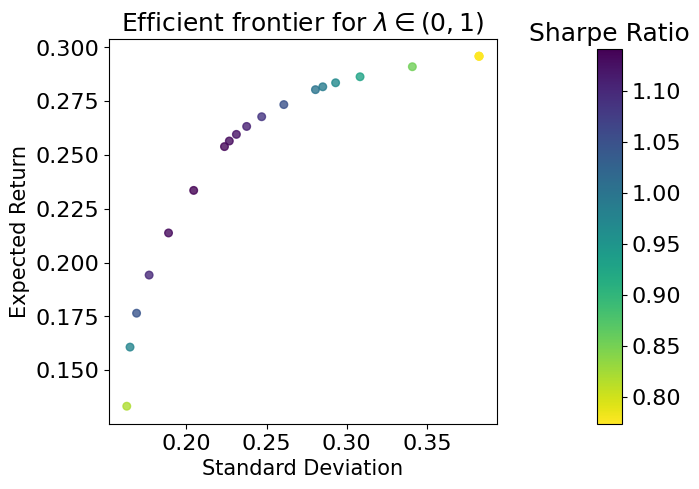

In [7]:
rcParams["font.size"] = 15
rcParams["axes.labelsize"] = 15

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(risk,returns, c = s_ratio, cmap='viridis_r', s=30, alpha=0.8)
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')
ax.set_title('Efficient frontier for $\lambda\in(0,1)$')

# Create the colorbar
norm = plt.Normalize(s_ratio.min(), s_ratio.max())
cax = fig.add_axes([1.1,0.11,0.05,0.75])
cax.set_title('Sharpe Ratio')
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'), cax=cax)

**5. Save the weights (in a variable) of the optimal portfolio (the one yielding highest Sharpe Ratio)**

In [8]:
# Find optimal weights
i = s_ratio.idxmax()
opt_weights_1 = weight[i]
print("Optimal SR: ", s_ratio[i])
print("Optimal weights:\n", opt_weights_1.reshape(-1,1))

Optimal SR:  1.1417185221513897
Optimal weights:
 [[ 3.90494923e-01]
 [ 2.96308528e-01]
 [-5.06889422e-23]
 [ 7.92518821e-02]
 [ 1.13418479e-23]
 [ 5.66095507e-02]
 [ 1.77335115e-01]
 [-4.94809535e-23]
 [-1.91994852e-23]]


#Exercise 2. Portfolio optimization allowing for short-selling

Now we relax our constraint $w_i>0 \ \forall i$. Thus, negative weights are understood as fractions of the money devoted to short selling a particular stock.

The problem will essentialy be the same, we only relax one of the constraints

**1. Define the problem**

In [9]:
#Define and set the number of assets under consideration
N = len(df.columns)

#Define and set the mean return of the assets
mu = df_returns.mean().values

#Define and set the covariance matrix of the returns
Sigma = df_returns.cov().values

#Initialize the weight vector as cp.Variable(N) of the cvxpy framework
w = cp.Variable(N)

#Investor risk aversion parameter
risk_aversion = cp.Parameter(nonneg=True)

#Define how the mean return of the portfolio is computed: ret = w^T * mu
mean_P = mu.T @ w #(@ performs matrix multiplication in Python)

#Define how the variance of the portfolio is computed,  w^T*mu*w, which is a quadratic form
var_P = cp.quad_form(w, Sigma)

#Define expression to be solved
expression = cp.Maximize((1-risk_aversion)*mean_P - risk_aversion*var_P)

##Define the constraints
constraints = [cp.sum(w)==1]

#Define the problem
prob = cp.Problem(expression, constraints)

**2. Compute and plot the efficient frontier**

In [10]:
returns = []
risk = []
weight = []
s_ratio = []
for i in np.linspace(0,1,21):
  if i==0: continue                  # Error was raised when calculating at i=0
  risk_aversion.value = i
  #Solve the problem
  prob.solve()

  #Obtain the optimal values
  returns.append(mean_P.value*252)
  risk.append(np.sqrt(var_P.value*252))
  weight.append(w.value)
  s_ratio.append(mean_P.value*252/np.sqrt(var_P.value*252))

# Save the Sharpe Ratio as a series
s_ratio = pd.Series(s_ratio)

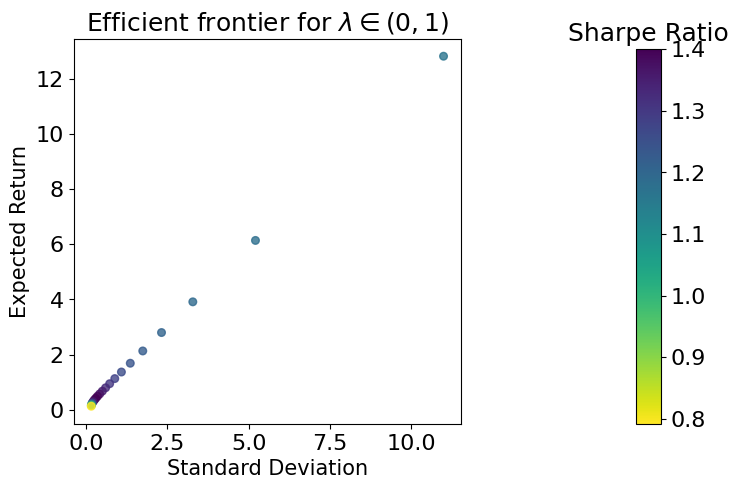

In [11]:
# Plot

fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.scatter(risk,returns, c = s_ratio, cmap='viridis_r', s=30, alpha=0.8)
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')
ax.set_title('Efficient frontier for $\lambda\in(0,1)$')

# Create the colorbar
norm = plt.Normalize(s_ratio.min(), s_ratio.max())
cax = fig.add_axes([1.25,0.11,0.05,0.75])
cax.set_title('Sharpe Ratio')
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='viridis_r'), cax=cax)

**3. Save the weights (in a variable) of the optimal portfolio (the one yielding highest Sharpe Ratio)**

In [12]:
# Find optimal
i = s_ratio.idxmax()
opt_weights_2 = weight[i]
print("Optimal SR: ", s_ratio[i])
print("Optimal weights:\n", opt_weights_2.reshape(-1,1))

Optimal SR:  1.4008009514787993
Optimal weights:
 [[ 0.5149116 ]
 [ 0.37077522]
 [-0.20222013]
 [ 0.60234052]
 [-0.0177271 ]
 [ 0.20685432]
 [ 0.23490931]
 [ 0.18677503]
 [-0.89661877]]


# Exercise 3. Future performance of optimal portfolios

1. Implement the optimal portfolios from the previous models (the ones yielding highest Sharpe Ratio) and check their performance in the period 2018-2023.

2. Implement the Equally Weighted (EW) portfolio and compare it to the other two.

  In the EW portfolio the weights are simply given by $w_i=1/N$.

3. Make a detailed analysis of the performance of the three portfolios. Compute:

  * Annualized return
  * Annualized volatility
  * Sharpe Ratio
  * Maximum Drawdown (MDD)

    A maximum drawdown (MDD) is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained

    $$MDD(T)=max_{\tau\in(0,T)}D(\tau)=max_{\tau\in(0,T)}\left[max_{t\in(0,\tau)}X(t)-X(\tau)\right]$$

    Put it simple: the maximum loss from a peak to a subsequent trough in a given time period. It is usually computed as a percentage

    $$MDD=\frac{Peak-Trough}{Peak}\cdot 100$$

  * Return over Maximum Drawdown (RoMaD)

    The RoMaD is computed as the average return divided by the MDD in a given period

    $$RoMaD(T)=\frac{\left<R\right>_T}{MDD(T)}$$

**1. Download the data**

In [13]:
start = datetime(2018, 1, 1)
end = datetime(2023, 1, 1)

#Apple, Microsoft, Amazon, Google, Nvidia, Telefonica, Santander, BBVA, Endesa
assets = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA", "TEF.MC", "SAN.MC", "BBVA.MC", "ELE.MC"]

df = yf.download(assets, start=start, end=end, interval="1d", progress=False, ignore_tz=True)["Adj Close"].dropna()

df_returns = np.log(1+df.pct_change()).dropna()


**2. Plot the evolution of the price of each portfolio**

In [14]:
# Calculate the weighted returns

# Equally weighted portfolio
N = len(df.columns)
ew_returns = df_returns*(1/N)

# Optimal portfolios w/ and w/o short selling
w1_returns = pd.DataFrame()
w2_returns = pd.DataFrame()
for col in df.columns:
  k=df.columns.tolist().index(col)
  w1_returns[col] = df_returns[col]*opt_weights_1[k]
  w2_returns[col] = df_returns[col]*opt_weights_2[k]

# Sum them all up
ew_tot_r = ew_returns.transpose().sum()
w1_tot_r = w1_returns.transpose().sum()
w2_tot_r = w2_returns.transpose().sum()

S_0 = df.transpose().sum()[0] # Starting price

# Convert the returns back into prices
ew_price = S_0*np.exp(np.cumsum(ew_tot_r))
w1_price = S_0*np.exp(np.cumsum(w1_tot_r))
w2_price = S_0*np.exp(np.cumsum(w2_tot_r))

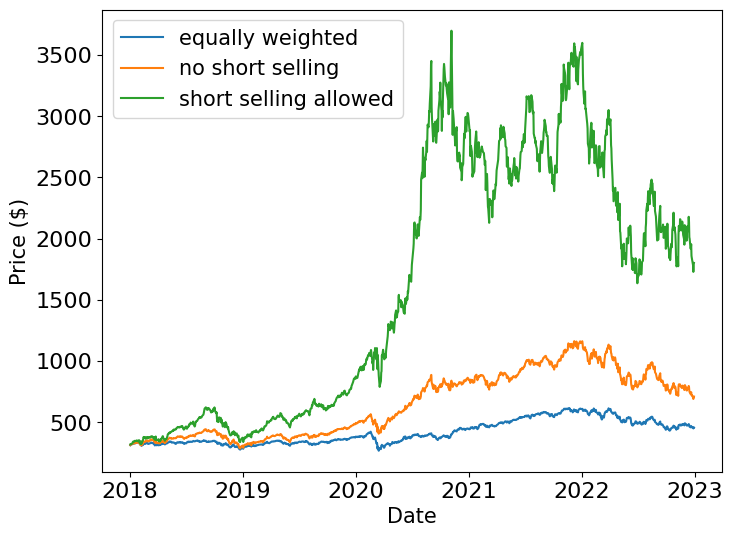

In [15]:
# Plot
plt.plot(ew_price, label='equally weighted')
plt.plot(w1_price, label='no short selling')
plt.plot(w2_price, label='short selling allowed')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

**3 Detailed analysis**

In [16]:
# Implement a function to do the analysis
def analysis(returns, prices):
  an_returns = returns.mean()*252
  an_vol = returns.std()*np.sqrt(252)
  SR = an_returns/an_vol
  max=0
  MDD=0
  # Calculate MDD
  for price in prices:
    if price > max: max=price
    elif (max-price)/max > MDD: MDD=(max-price)/max
    else: continue
  # Calculate RoMaD
  RoMaD = an_returns/MDD

  return an_returns, an_vol, SR, MDD*100, RoMaD

In [17]:
ew_details = analysis(ew_tot_r, ew_price)
w1_details = analysis(w1_tot_r, w1_price)
w2_details = analysis(w2_tot_r, w2_price)

In [19]:
# Place all the data in a DataFrame
Det = pd.DataFrame([ew_details,w1_details,w2_details],index=['EW','No short','Short'], columns=['AnRet', 'AnVol', 'SR', 'MDD(%)', 'RoMaD'])
Det

,AnRet,AnVol,SR,MDD(%),RoMaD
EW,0.079314,0.238491,0.332565,36.733210,0.215919
No short,0.168454,0.310311,0.542856,40.599945,0.414912
Short,0.356677,0.482138,0.739783,55.772466,0.639522
